In [7]:
import os
def dataset_from_text_file(file_names):
    if isinstance(file_names, str):
        file_names = [file_names]
    for file_name in file_names:
        with open(file_name, 'r') as f:
            text = f.read()
        print(text)
    return None
data_dir = '../docs/interviews'
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
with open(files[0], 'r') as f:
    text = f.read()
# kapitza = dataset_from_text_file(file_names=files)

In [6]:
# !pip install langchain spacy
# !python -m spacy download en_core_web_sm
from langchain.text_splitter import SpacyTextSplitter
text_splitter = SpacyTextSplitter(chunk_size=256, chunk_overlap=256//4)

In [8]:
# functions to train and test
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
base_model, tokenizer = FastLanguageModel.from_pretrained( model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # "model",
    max_seq_length = 8192, dtype = None, load_in_4bit = True)
tokenizer = get_chat_template(tokenizer, chat_template = "llama-3", 
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)
FastLanguageModel.for_inference(base_model) 

def ask_llm(prompt, user, n_rep=1):
    inputs = tokenizer.apply_chat_template( [{"system": prompt,\
                                          "from": "human", \
                                          "value": user}],
    tokenize = True, add_generation_prompt = True, return_tensors = "pt").to(base_model.device)
    questions = []
    for _ in range(n_rep):
        outputs = base_model.generate(input_ids = inputs, max_new_tokens = 128, use_cache = True)
        full_output = tokenizer.batch_decode(outputs)
        answer = full_output[0].split('|end_header_id|>\n\n')[-1].rstrip('<|eot_id|>')
        questions.append(answer)
    
    return questions[0] if len(questions) == 1 else questions

/home/zipa/miniconda3/envs/unsloth_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.9.post3: Fast Llama patching. Transformers = 4.45.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.635 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [9]:
prompt1 = """Ниже дан текст в форме вопроса, адресованному Сергею Капице. Пожалуйста, выведи новый {text}, представляющий из себя сокращенный вопрос,перепиcанный простыми словами.
[вопрос]: {question}.
Выведи ответ в формате JSON, используя только русский язык: {"question": {text}}."""
prompt2 = """Ниже дан текст в форме вопроса, адресованному Сергею Капице и его ответ.
Пожалуйста, выведи новый {text}, представляющий из себя сокращенный ответ, сохранивший стиль. Ответ должен по смыслу чётко соответствовать вопросу.
[вопрос]: {question}
[ответ]: {answer}
Выведи ответ в формате JSON, используя только русский язык: {"answer": {answer}}."""

prompt3 = """На вход ты получил ```Текст```. Выдели несколько тем в тексте и перепиши его в виде отдельных абзацев, сохранив стиль."""
prompt4 = """На вход ты получил ```Ответ```. Придумай вопрос, подходящий к такому ответу."""
question = """Если взять поколения кому сегодня за сорок, навскидку они процитируют: "О сколько нам открытий чудных готовит просвещенья дух..." Так кто был популярнее, Вы, Сергей Петрович, или Александр Сергеевич?"""
answer = """Не преувеличивайте, Пушкин, конечно, был популярнее. Алла Пугачева была популярнее...  Да, это стихотворение стало нашим брендом. Эпиграф нашел наш режиссер Левкович. Кстати, это стихотворение никогда не было опубликовано в сочинениях Пушкина. Оно рассеяно у него в отрывках... У Натана Эйдельмана есть целое эссе на эту тему.  Название же передачи - "Очевидное-невероятное" - предложила моя помощница Железова. По-моему, до этого оно появлялось в фильмах, снятых Киевской киностудией. Сегодня нам приходится это словосочетание защищать, поскольку его уже пытались несколько раз украсть. Мы даже специально получили авторское свидетельство на название телепередачи - "Очевидное-невероятное"."""

import json

new_question = json.loads(ask_llm("", prompt1.replace("{question}", question)))['question']
new_answer = json.loads(ask_llm("", prompt2.replace("{question}", new_question).replace("{answer}", answer)))['answer']
# ask_llm("", prompt2.replace("{question}", question).replace("{answer}", answer))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [10]:
prompt3 = """На вход ты получил ```Текст```. Выдели несколько тем в тексте и перепиши его в виде отдельных абзацев, сохранив стиль."""
prompt3 = """Ниже дан текст рассуждений Сергея Капицы. Перепиши этот текст в виде набора тезисов, сохранив стиль.
[текст]: {text}.
Выведи ответ в формате JSON, используя только русский язык: {"theme0": {тезис0}, "theme1": {тезис1}, ...}. Не добавляй больше ничего к выдаче."""
ret = ask_llm("", prompt3.replace("{text}", answer))

In [15]:
# print(*[ans.strip() for ans in answer.split('.') if len(ans)], sep = '.\n')
items = text_splitter.split_text(answer)
print(len(items))

3


/home/zipa/miniconda3/envs/unsloth_env/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [22]:
question

'Если взять поколения кому сегодня за сорок, навскидку они процитируют: "О сколько нам открытий чудных готовит просвещенья дух..." Так кто был популярнее, Вы, Сергей Петрович, или Александр Сергеевич?'

In [67]:
prompt_eval = """Ниже дана пара вопрос-ответ, оцени их согласованность по логике по шкале от 0 до 5.
0 - вопрос и ответ не соотносятся друг с другом.
1 - в ответе слишком много лишних слов.
2 - в ответе много деталей, о которых никто не спрашивал.
3 - в ответе содержатся детали, не соответствующие вопросу.
4 - вопрос и ответ почти походят на диалог, но есть небольшая несогласованность, нечёткость.
5 - вопрос и ответ идеально подходят друг к другу.
[вопрос]: {question}
[ответ]: {answer}
Выведи оценку {value} в виде JSON: {"evaluation": {value}}. Не добавляй анализ и постронний текст."""
for q in [question, new_question]:
    for a in [answer, new_answer]:
        text = ask_llm("", prompt_eval.replace("{question}", q).replace("{answer}", a))
        print(text, q, a)

{"evaluation": 2} Если взять поколения кому сегодня за сорок, навскидку они процитируют: "О сколько нам открытий чудных готовит просвещенья дух..." Так кто был популярнее, Вы, Сергей Петрович, или Александр Сергеевич? Не преувеличивайте, Пушкин, конечно, был популярнее. Алла Пугачева была популярнее...  Да, это стихотворение стало нашим брендом. Эпиграф нашел наш режиссер Левкович. Кстати, это стихотворение никогда не было опубликовано в сочинениях Пушкина. Оно рассеяно у него в отрывках... У Натана Эйдельмана есть целое эссе на эту тему.  Название же передачи - "Очевидное-невероятное" - предложила моя помощница Железова. По-моему, до этого оно появлялось в фильмах, снятых Киевской киностудией. Сегодня нам приходится это словосочетание защищать, поскольку его уже пытались несколько раз украсть. Мы даже специально получили авторское свидетельство на название телепередачи - "Очевидное-невероятное".
{"evaluation": 4} Если взять поколения кому сегодня за сорок, навскидку они процитируют: "

In [49]:
new_answer

'Не преувеличивайте, Пушкин был популярнее. Алла Пугачева была популярнее, и это стихотворение стало нашим брендом.'

CHATGPT prompt

In [25]:
chat_prompt = f"""Дан вопрос:
```{question}```
Дан ответ на этот вопрос:
```{answer}```
Вопрос и ответ очень размыты.
1. Перепиши вопрос простыми словами, выдели из ответа главную мысль и перепиши с сохранением стиля.
2. Раздели ответ на набор тезисов. Для каждого тезиса подготовь простой и лаконичный вопрос. Перепиши каждый тезис в виде ответа на этот вопрос с сохранением изначального стиля. Все сущности в вопросе должны быть чётко определены, ответ может ссылаться на понятия, ясные из контекста.
3. Все пары получившихся вопросов и ответов выведи массива пар в формате json с полями "question", "answer"."""

[
    {
        "question": "Кто из вас более известен: вы или Пушкин?",
        "answer": "Не преувеличивайте, Пушкин, конечно, был популярнее. Алла Пугачева была популярнее..."
    },
    {
        "question": "Почему стихотворение стало брендом вашей передачи?",
        "answer": "Да, это стихотворение стало нашим брендом. Эпиграф нашел наш режиссер Левкович."
    },
    {
        "question": "Где можно найти полное стихотворение Пушкина?",
        "answer": "Кстати, это стихотворение никогда не было опубликовано в сочинениях Пушкина. Оно рассеяно у него в отрывках..."
    },
    {
        "question": "Есть ли исследование о стихотворении Пушкина?",
        "answer": "У Натана Эйдельмана есть целое эссе на эту тему."
    },
    {
        "question": "Кто предложил название вашей передачи 'Очевидное-невероятное'?",
        "answer": "Название же передачи - 'Очевидное-невероятное' - предложила моя помощница Железова."
    },
    {
        "question": "Где ранее использовалось это название?",
        "answer": "По-моему, до этого оно появлялось в фильмах, снятых Киевской киностудией."
    },
    {
        "question": "Почему вы защищаете название вашей передачи?",
        "answer": "Сегодня нам приходится это словосочетание защищать, поскольку его уже пытались несколько раз украсть."
    },
    {
        "question": "Как вы защищаете название вашей передачи?",
        "answer": "Мы даже специально получили авторское свидетельство на название телепередачи - 'Очевидное-невероятное'."
    }
]

In [42]:
from datasets import Dataset

def interview_dataset(file="../finetuning/int1.txt"):
    with open(file, 'r') as f:
        text = f.read()
    dataset = []
    for conv in data.split('\n\n'):
        if len(conv):
            roles = ['user', 'assistant']
            play = []
            for i_role, item in enumerate(conv.split('\n')):
                play.append({'content': item.strip('–\t').strip(' '), 'role': roles[i_role % 2]})
            dataset.append(play)    
    return Dataset.from_dict({'conversations': dataset})
    # [{'content': question, 'role': 'user'}, {'content': answer, 'role': 'assistant'}]

data = interview_dataset()

In [63]:
from datasets import load_dataset
from torch.utils.data import DataLoader

cv_17 = load_dataset("mozilla-foundation/common_voice_17_0", "ru", split="train", trust_remote_code=True)
# dataloader = DataLoader(cv_17, batch_size=32)

In [67]:
items = cv_17['sentence']

In [74]:
for s in items:
    if 'Капица' in s:
        print(s)

In [13]:
#cv_17['path']
data_folder = "/home/zipa/.cache/huggingface/datasets/downloads/extracted/2c4bea01a26146afd7522d1621e2aaab4c666abe3068f29739ef3ce65c6c4814/ru_train_0/"

In [ ]:
from TTS.api import TTS
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=True)

# generate speech by cloning a voice using default settings
tts.tts_to_file(text="В этом варианте тикстуру кожи для каждого кадра этого видео генерирует отдельная нейросеть. Так получился текущий вариант.",
                file_path="output.wav",
                speaker_wav="/path/to/target/speaker.wav",
                language="ru")

In [58]:
def walls2code(has_left, has_down, has_right, has_up):
    code = None
    if has_left:
        if has_down:
            if has_up:
                if has_right:
                    code = 15
                else:
                    code = 13
            else:
                if has_right:
                    code = 14
                else:
                    code = 5
        else:
            if has_up:
                if has_right:
                    code = 12
                else:
                    code = 8
            else:
                if has_right:
                    code = 9
                else:
                    code = 1
    else:
        if has_down:
            if has_up:
                if has_right:
                    code = 11
                else:
                    code = 10
            else:
                if has_right:
                    code = 6
                else:
                    code = 4
        else:
            if has_up:
                if has_right:
                    code = 7
                else:
                    code = 2
            else:
                if has_right:
                    code = 3
                else:
                    code = 0
    return code

# returns has_left, has_down, has_right, has_up
def code2walls(code):
    match code:
        case 0:
            return False, False, False, False
        case 1:
            return True, False, False, False
        case 2:
            return False, False, False, True
        case 3:
            return False, False, True, False
        case 4:
            return False, True, False, False
        case 5:
            return True, True, False, False
        case 6:
            return False, True, True, False
        case 7:
            return False, False, True, True
        case 8:
            return True, False, False, True
        case 9:
            return True, False, True, False
        case 10:
            return False, True, False, True
        case 11:
            return False, True, True, True
        case 12:
            return True, False, True, True
        case 13:
            return True, True, False, True
        case 14:
            return True, True, True, False
        case 15:
            return True, True, True, True

# robo mouse challenge
import numpy as np
from queue import Queue
from matplotlib import pyplot as plt

class Labyrinth:
    def __init__(self):
        # generate random walls
        self.right_edges = np.zeros((15, 16)) # 0 or 1
        self.up_edges = np.zeros((15, 16)) # 0 or 1
    
    def _reveal_cell(self, x, y):
        # determine cell code, using edges map
        has_left = x > 0 and self.right_edges[x - 1, y]
        has_down = y > 0 and self.up_edges[x, y - 1]
        has_right = x < 15 and self.right_edges[x, y]
        has_up = y < 15 and self.up_edges[x, y]
        return walls2code(has_left, has_down, has_right, has_up)

    def set_code(self, x, y, cell_code):
        has_left, has_down, has_right, has_up = code2walls(cell_code)
        # update walls
        if x < 15:
            self.right_edges[x, y] = has_right
        if y < 15:
            self.up_edges[x, y] = has_up
        if x > 0:
            self.right_edges[x - 1, y] = has_left
        if y > 0:
            self.up_edges[x, y - 1] = has_down

    def labyrinth(self):
        obj = np.zeros((16, 16), np.int32)
        for x in range(16):
            for y in range(16):
                obj[x, y] = self.reveal_cell(x, y)
        return obj

    def draw(self):
        # horizontal (up walls)
        for x in range(16):
            for y in range(15):
                if u[x, y]:
                    plt.plot([x, x+1], [y, y], 'b')

        for x in range(15):
            for y in range(16):
                if r[x, y]:
                    plt.plot([x, x], [y, y+1], 'b')
        plt.plot([0, 0], [0, 16], color='gray')
        plt.plot([0, 16], [0, 0], color='gray')
        plt.plot([16, 16], [0, 16], color='gray')
        plt.plot([0, 16], [16, 16], color='gray')
        plt.axis('off')
        plt.show()

class Environment(Labyrinth):
    def __init__(self):
        Labyrinth.__init__(self)
        self.right_edges = np.random.randint(0, 2, size=(15, 16)) # 0 or 1
        self.up_edges = np.random.randint(0, 2, size=(16, 15)) # 0 or 1

    def reveal_cell(self, x, y):
        return self._reveal_cell(x, y)

class Agent:
    position: int # 0 .. 15
    data: Labyrinth
    revealed: np.zeros((16, 16), dtype=bool)

    environment: Environment

    def __init__(self, environment: Environment):
        self.environment = environment
        self.steps_count = 0
        # (x, y), last_gap
        self.queue = Queue(((0, 0), 0))

    def end_of_search(self):
        return (self.right_walls == -1).sum() == 0 and (self.up_walls == -1).sum() == 0

    # depth - first search
    def step(self):
        # in each state determine where to go next
        # in each new cell we decode labyrinth
        # we remember all steps we made, never repeat same action again, always choose next step determinately
        # so history is a tree of all possible ways (positional idx of next cell)
        # we pop from node and go backwards when we reach deadlock 
        # we don't append new node to our path, if it was revealed, we check only new nodes
        # during path search we perform search in depth along the tree we build
        # we will use dictionaries for tree representation
        (x, y), current_gap = self.queue.pop(-1)

        cell_code = self.environment.reveal_cell(x, y)
        data.set_code(x, y, cell_code) # update info
        self.revealed[x, y] = True # cell was checked

        # push at the beginning
        # all possible directions
        # if we have more then one passage, then we sould store current steps count 
        # from the last fork (cell with 0 or 1 wall, e.g. cell_code <= 4 )
        this_is_fork = cell_code <= 4
        this_is_deadlock = cell_code >= 11
        if this_is_deadlock: # agent will go back to the last fork
            self.steps_count += current_gap
            return
            
        if this_is_fork:
            current_gap = 0
        else:
            current_gap += 1
        
        self.steps_count += 1

        if has_down and not self.revealed[x, y - 1]:
            self.queue.push(((x, y - 1), current_gap), -1)
        if has_left and not self.revealed[x - 1, y]:
            self.queue.push(((x - 1, y), current_gap), -1)
        if has_up and not self.revealed[x, y + 1]:
            self.queue.push(((x, y + 1), current_gap), -1)
        if has_right and not self.revealed[x + 1, y]:
            self.queue.push(((x + 1, y), current_gap), -1)
        

    def explore(self):
        while not self.end_of_search():
            self.step()
            
        answer = np.zeros((16, 16), np.int32)
        for x in range(16):
            for y in range(16):
                r = self.right_walls[x, y]
                l = self.right_walls[x - 1, y]
                u = self.up_walls[x, y]
                d = self.up_walls[x, y - 1]
                answer[x, y] = walls2code(l, d, r, u)
        # report result
        return answer, self.steps_count

def test_codes():
    for code in range(16):
        assert(walls2code(*code2walls(code)) == code)
        x = code2walls(code)
        assert(code2walls(walls2code(*x)) == x)

In [59]:
env = Environment()
r, u = env.right_edges, env.up_edges
obj = env.labyrinth()
# agent = Agent(env)

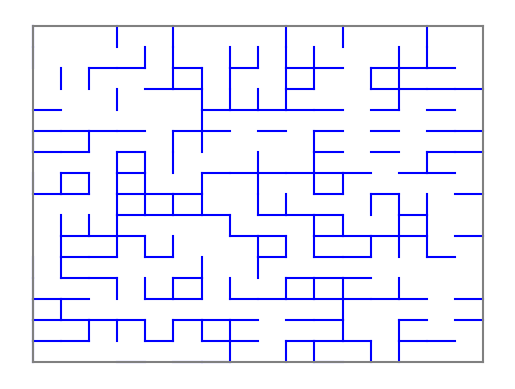

In [60]:
env.draw()

In [61]:
obj

array([[ 3,  7, 11, 11,  6,  0,  0,  0,  7,  4,  7, 10, 10,  4,  3,  3],
       [ 1,  8, 15, 13, 15, 11, 11,  4, 12, 10, 13, 10,  4,  3,  1,  1],
       [ 0,  3,  8,  4,  8, 13, 15,  4,  9,  0,  3,  2,  4,  9,  2,  4],
       [ 2, 14,  2,  6,  0,  3, 12, 11, 15, 11, 13, 10,  6,  1,  2,  6],
       [ 0, 12,  4, 12,  4, 12,  5, 12, 15, 14,  0,  0,  1,  2,  6,  1],
       [ 2, 14,  2, 15, 10, 14,  0, 12, 13, 14,  3,  2,  4,  7, 15,  6],
       [ 2, 15, 10, 14,  3,  1,  0, 12,  6,  8, 14,  7, 11, 14,  1,  1],
       [ 3, 12, 10, 15,  5,  0,  7,  5,  1,  2,  5,  1, 12, 14,  7,  4],
       [ 1,  1,  0,  8,  6,  7, 13, 11,  6,  7,  4,  2, 15,  5,  9,  0],
       [ 3,  2, 10, 11, 13, 14,  0, 12,  5,  8,  4,  0, 12, 11, 15,  6],
       [12, 10, 10, 15, 10, 15, 11, 13, 11, 11, 11, 10, 13, 14, 12,  5],
       [ 1,  7,  6, 12, 10, 13, 15,  4,  9,  8,  5,  0,  0,  1,  1,  3],
       [ 3,  1,  1,  8,  4,  3,  8,  6,  8,  4,  2, 10, 10, 11, 10,  5],
       [ 9,  7, 10, 11,  4,  9,  7, 15,  4,  2,  4,